# Kerchunk Useful Recipes with NASA Earthdata

#### *Author: Dean Henze, PO.DAAC*

*Reference herein to any specific commercial product, process, or service by trade name, trademark, manufacturer, or otherwise, does not constitute or imply its endorsement by the United States Government or the Jet Propulsion Laboratory, California Institute of Technology.*

## Summary

This notebook goes through several functionalities of kerchunk, specifically using it with NASA Earthdata and utilizing the `earthaccess` package. It is meant to be a quick-start reference that introduces some key capabilities / characteristics of the package once a user has a high-level understanding of kerchunk as well as the cloud-computing challenges it addresses (see references in the *Prerequisite knowledge* section below). In short, kerchunk is a Python package to create "reference files", which can be thought of as road maps for the computer to efficiently navigate through large arrays in an Earthdata file (or any file). Once a reference file for a data set is created, it can be accessed and used to e.g. to lazy load data faster, access subsets of the data quicker (spatially, temporally, or any other dimension in the data set), and in some cases perform computations faster.

The functionalities of kerchunk covered in this notebook are:

1. **Generating a reference file in JSON format for a year of the MUR 0.01 degree resolution sea surface temperature (SST) data set**, available on PO.DAAC. It also covers speeding up the generation using parallel computing. MUR 0.01 is a daily, gridded global data set (doi [10.5067/GHGMR-4FJ04](https://doi.org/10.5067/GHGMR-4FJ04)).
2. **Generating a reference file in PARQUET format** for a year of the MUR 0.01 degree data. This will become important as cloud data sets get so large that saving their reference files in JSON format also becomes too large. We find in Section 2 that saving the same reference information in PARQUET format reduced disk size by ~30x. 
3. **Combining reference files**. The ability to combine reference files together rather than having to create the combined product from scratch is important since it can save computing resources/time. This notebooks explores (3.1) Adding an extra day of the MUR record to the reference file created in Section 1, and (3.2) Creating a reference file for an additional year of MUR data and combining it with the reference file created in Section 1.
4. **Using the reference file to perform a basic analysis on the MUR data set with a parallel computing cluster.** Parallel computing on both a local and distributed cluster are tested. For the local cluster, we are able to run all computations successfully. For the distributed cluster, we are only able to run computations if the reference file is first loaded fully into memory.

## Requirements, prerequisite knowledge, learning outcomes

#### Requirements to run this notebook

* Earthdata login account: An Earthdata Login account is required to access data from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account.

* Compute environment: This notebook is meant to be run in the cloud (AWS instance running in us-west-2). We used an `m6i.8xlarge` EC2 instance (32 CPU's, 128 GiB memory) to complete Section 4 on parallel computing, although this is likely overkill for the other sections. At minimum we recommend a VM with 10 CPU's to make the parallel computations in Sections 1.2.1 and 3.2 faster.

* Optional Coiled account: To run the optional sections on distributed clusters, Create a coiled account (free to sign up), and connect it to an AWS account. For more information on Coiled, setting up an account, and connecting it to an AWS account, see their website [https://www.coiled.io](https://www.coiled.io). 

#### Prerequisite knowledge

* This notebook covers kerchunk functionality but does not present the high-level ideas behind it. For an understanding of reference files and how they are meant to enhance in-cloud access to file formats that are not cloud optimized (such netCDF, HDF), please see e.g. this [kerchunk page](https://fsspec.github.io/kerchunk/), or [this page on virtualizarr](https://virtualizarr.readthedocs.io/en/latest/) (a package with similar functionality).

* Familiarity with the `earthaccess` and `Xarray` packages. Familiarity with directly accessing NASA Earthdata in the cloud. 

* The Cookbook notebook on [Dask basics](https://podaac.github.io/tutorials/notebooks/Advanced_cloud/basic_dask.html) is handy for those new to parallel computating and wanting to implement it in Sections 1.2.1 and 3.2.

#### Learning Outcomes

This notebook demonstrates several recipes for key kerchunk functionalities with NASA Earthdata. It is meant to be used after the user has a high level understanding of kerchunk and the challenges it is trying to solve, at which point this notebook: 

* Demonstrates how to implement the package,
* Highlights several characteristics of the package which will likely be of interest for utilizing it with Earthdata in common workflows. 

## Import Packages
We ran this notebook in a Python 3.12 environment. The minimal working install we used to run this notebook from a clean environment was:
```
pip install kerchunk==0.2.6 fastparquet==2024.5.0 xarray==2024.1.0 earthaccess==0.11.0 fsspec==2024.10.0 "dask[complete]"==2024.5.2 h5netcdf==1.3.0 ujson==5.10.0 matplotlib==3.9.2 jupyterlab jupyter-server-proxy
```
And optionally:
```
pip install coiled==1.58.0
```

In [11]:
# Built-in packages
import os
import json

# Filesystem management 
import fsspec
import earthaccess

# Data analysis
import xarray as xr
from kerchunk.df import refs_to_dataframe
from kerchunk.hdf import SingleHdf5ToZarr
from kerchunk.combine import MultiZarrToZarr

# Parallel computing 
import multiprocessing
from dask import delayed
import dask.array as da
from dask.distributed import Client

# Other
import ujson
import matplotlib.pyplot as plt

In [2]:
import coiled

## Other Setup

In [3]:
xr.set_options( # display options for xarray objects
    display_expand_attrs=False,
    display_expand_coords=True,
    display_expand_data=True,
)

## 1. Generating a reference file in JSON format for one year of MUR 0.01 degree SST

### 1.1 Locate Data File S3 endpoints in Earthdata Cloud 
The first step is to find the S3 endpoints to the files and generate file-like objects to use with kerchunk. Handling access credentials to Earthdata and then finding the endpoints can be done a number of ways (e.g. using the `requests`, `s3fs` packages) but we choose to use the `earthaccess` package for its convenience and brevity. We will get two years of MUR files, from beginning 2019 to end 2020. 

In [5]:
# Get Earthdata creds
earthaccess.login()

Enter your Earthdata Login username:  deanh808
Enter your Earthdata password:  ········


In [6]:
# Get AWS creds
fs = earthaccess.get_s3_filesystem(daac="PODAAC")

In [7]:
# Locate MUR file information for years 2019-2020 and generate file-like objects:
granule_info = earthaccess.search_data(
    short_name="MUR-JPL-L4-GLOB-v4.1",
    temporal=("2019-01-01", "2020-12-31"),
    )
fobjs = earthaccess.open(granule_info)

QUEUEING TASKS | :   0%|          | 0/732 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/732 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/732 [00:00<?, ?it/s]

In [8]:
# Endpoints can be found in this attribute:
example_endpoint = fobjs[0].full_name
example_endpoint

's3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20190101090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc'

### 1.2 Generate kerchunk reference files for each MUR file in year 2019
It is necessary to create reference files for each data file individually before they can be combined into a single reference file for the entire record. The time for generating many of these individual files can add up, so this section also covers the option to use parallel computing.

First, define a small wrapper function around kerchunk and earthaccess packages.

In [9]:
def single_ref_earthaccess(fobj, dir_save=None):
    """
    Create a reference for a single data file. "fobj" (earthaccess.store.EarthAccessFile 
    object) is the output from earthaccess.open(), which also has the file endpoint. 
    Option to save as a JSON to direcotry "dir_save", with file name of the corresponding 
    data file with ".json" appended. Otherwise reference info is returned.
    """
    endpoint = fobj.full_name
    reference = SingleHdf5ToZarr(fobj, endpoint, inline_threshold=0).translate()
    
    if dir_save is not None:
        with open(dir_save + endpoint.split('/')[-1]+'.json', 'w') as outf:
            outf.write(ujson.dumps(reference))
    else:
        return reference, endpoint # returns both the kerchunk reference and the path the file on podaac-ops-cumulus-protected

Which can immediately be used to create a reference file and open one of the MUR files with Xarray, at which point it can be used just as if we had opened the MUR netCDF file directly:

In [8]:
%%time
# Create reference file:
reference, endpoint = single_ref_earthaccess(fobjs[0])

CPU times: user 2.44 s, sys: 1.01 s, total: 3.45 s
Wall time: 13.9 s


In [12]:
# Open data using the reference file, using a small wrapper function around xarray's open_dataset. 
# This will shorten code blocks in other sections. 
def opendf_withref(ref, fs_data):
    """
    "ref" is a kerchunk reference file or object. "fs_data" is a filesystem with credentials to
    access the actual data files. 
    """
    storage_opts = {"fo": ref, "remote_protocol": "s3", "remote_options": fs_data.storage_options}
    fs_ref = fsspec.filesystem('reference', **storage_opts)
    m = fs_ref.get_mapper('')
    data = xr.open_dataset(
        m, engine="zarr", chunks={},
        backend_kwargs={"consolidated": False}
        )
    return data

In [12]:
%%time
data = opendf_withref(reference, fs)
print(data)

<xarray.Dataset>
Dimensions:           (time: 1, lat: 17999, lon: 36000)
Coordinates:
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time              (time) datetime64[ns] 2019-01-01T09:00:00
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    analysis_error    (time, lat, lon) float32 dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    dt_1km_data       (time, lat, lon) timedelta64[ns] dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    mask              (time, lat, lon) float32 dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
Attributes: (47)
CPU times: user 103 ms, sys: 8.7 ms, total: 111 ms
Wall time: 469 ms


**For us, reference file creation took ~10 seconds, so processing a year would take *10 x 365 ~ 60 minutes***. One could easily write a simple for-loop to accomplish this, e.g.

```
for fobj in fobjs[:365]:
    single_ref_earthaccess(fobj, dir_save=<directory of your choice>)
```

However, we speed things up using basic parallel computing. 

### 1.2.1 Parallelize using Dask local cluster
If using the suggested `m6i.8xlarge` AWS EC2 instance, there are 32 CPUs available and each should have enough memory that we can utilize all 32 at once. If working on a different VM-type, change the `n_workers` in the call to `Client()` below as needed.

In [13]:
## Save reference JSONs in this directory:
dir_refs_indv_2019 = './reference_jsons_individual_2019/'
!mkdir $dir_refs_indv_2019

In [13]:
# Check how many cpu's are on this VM:
print("CPU count =", multiprocessing.cpu_count())

CPU count = 32


In [14]:
# Start up cluster and print some information about it:
client = Client(n_workers=32, threads_per_worker=1)
print(client.cluster)
print("View any work being done on the cluster here", client.dashboard_link)

LocalCluster(01fc9997, 'tcp://127.0.0.1:36457', workers=32, threads=32, memory=122.32 GiB)
View any work being done on the cluster here https://cluster-idaxm.dask.host/jupyter/proxy/8787/status


In [16]:
%%time

# Setup parallel computations:
single_ref_earthaccess_par = delayed(single_ref_earthaccess)
tasks = [single_ref_earthaccess_par(fo, dir_save=dir_refs_indv_2019) for fo in fobjs[:365]]

# Run parallel computations:
results = da.compute(*tasks)

/opt/coiled/env/lib/python3.12/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 51.61 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 1min 26s, sys: 18.8 s, total: 1min 45s
Wall time: 5min 18s


### 1.2.2 Optional Alternative: Parallelize using distributed cluster with Coiled
At PO.DAAC we have been testing the third party software/package Coiled which makes it easy to spin up distributed computing clusters in the cloud. Since we suspect that Coiled may become a key member of the Cloud ecosystem for earth science researchers, this optional section is included, which can be used as an alternative to Section 1.2.1 for generating the reference files in parallel.

In [ ]:
## Save reference JSONs in this directory:
dir_refs_indv_2019 = './reference_jsons_individual_2019/'
!mkdir $dir_refs_indv_2019

In [16]:
%%time

## --------------------------------------------
## Create single reference files with parallel computing using Coiled
## --------------------------------------------

# Wrap `create_single_ref` into coiled function:
single_ref_earthaccess_par = coiled.function(
    region="us-west-2", spot_policy="on-demand", 
    vm_type="m6i.large", n_workers=16
    )(single_ref_earthaccess)

# Begin computations:
results = single_ref_earthaccess_par.map(fobjs[:365])

# Save results to JSONs as they become available:
for reference, endpoint in results:
    name_ref = dir_refs_indv_2019 + endpoint.split('/')[-1].replace('.nc', '.json')
    with open(name_ref, 'w') as outf:
        outf.write(ujson.dumps(reference))

Output()

Output()

CPU times: user 58.2 s, sys: 17.1 s, total: 1min 15s
Wall time: 9min 7s


In [17]:
single_ref_earthaccess_par.cluster.shutdown()

### 1.3 Create the combined reference file and use it to open the data
However the single reference files were generated in the previous section, they can now be used to create a single reference file for the entire year 2019. The computation time for this step can also be decreased with parallel computing, but in this case serial computing is used.

***Important: Modify the `time_invariant_dims_and_coords` list in the next block. List all the NC dimension and coordinate names other than time. This is necessary to ensure they stay 1D and do not get a dummy time dimension added to them.***

In [ ]:
time_invariant_dims_and_coords = []

In [18]:
%%time

## --------------------------------------------
## Create combined reference file
## --------------------------------------------

ref_files_indv = [dir_refs_indv_2019+f for f in os.listdir(dir_refs_indv_2019) if f.endswith('.json')]
ref_files_indv.sort()

## Combined reference file
kwargs_mzz = {
    'remote_protocol':"s3", 
    'remote_options':fs.storage_options, 
    'concat_dims':["time"]
    'identical_dims':time_invariant_dims_and_coords
    }
mzz = MultiZarrToZarr(ref_files_indv, **kwargs_mzz)
ref_combined = mzz.translate()

 # Save reference info to JSON:
with open("ref_combined_2019.json", 'wb') as outf:
    outf.write(ujson.dumps(ref_combined).encode())

CPU times: user 27 s, sys: 6.18 s, total: 33.2 s
Wall time: 2min 30s


In [19]:
%%time
# Open the portion of the MUR record corresponding to the reference file created:
data = opendf_withref(json.load(open("ref_combined_2019.json")), fs)
print(data)

<xarray.Dataset>
Dimensions:           (time: 365, lat: 17999, lon: 36000)
Coordinates:
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time              (time) datetime64[ns] 2019-01-01T09:00:00 ... 2019-12-3...
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    analysis_error    (time, lat, lon) float32 dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    dt_1km_data       (time, lat, lon) timedelta64[ns] dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    mask              (time, lat, lon) float32 dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    sst_anomaly       (time, lat, lon) float32 dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
Attributes: (47)
CPU times: user 2.27

The data will open quickly now that we have the reference file. Compare that to an attempt at opening these same files with `Xarray` the "traditional" way with a call to `xr.open_mfdataset()`. On a smaller machine, the following line of code will either fail or take a long (possibly very long) amount of time:

In [33]:
## You can try un-commenting and running this but your notebook will probably crash:
# data = xr.open_mfdataset(fobjs[:365])

## 2. Generate the same MUR reference file but in PARQUET format

For larger datasets, the combined reference file in JSON format can become large. For example, if we wanted to create a reference JSON for the entire MUR 0.01 degree record it is estimated to be 1-2 GB, and the MUR data set isn't even *that* large in the scheme of things. One solution to this is to save the reference information in PARQUET format (demonstrated in this section) which reduces the disk space required.

Instead of re-creating all individual reference files, this section will load the combined 2019 reference file, then re-save in parquet format and use it to open the MUR data.

In [20]:
ref_combined_2019 = json.load(open("ref_combined_2019.json"))

In [21]:
%%time
# Save reference info to parquet:
refs_to_dataframe(ref_combined_2019, "ref_combined_2019.parq")

CPU times: user 3.26 s, sys: 140 ms, total: 3.4 s
Wall time: 3.22 s


In [22]:
%%time
data = opendf_withref("ref_combined_2019.parq", fs)
print(data)

<xarray.Dataset>
Dimensions:           (time: 365, lat: 17999, lon: 36000)
Coordinates:
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time              (time) datetime64[ns] 2019-01-01T09:00:00 ... 2019-12-3...
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    analysis_error    (time, lat, lon) float32 dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    dt_1km_data       (time, lat, lon) timedelta64[ns] dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    mask              (time, lat, lon) float32 dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    sst_anomaly       (time, lat, lon) float32 dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
Attributes: (47)
CPU times: user 65.4

In [23]:
## Compare size of JSON vs parquet, printed in MB
    # JSON
print("JSON:", os.path.getsize("ref_combined_2019.json")/10**6, "MB")
    # parquet
size_parq = 0 
for path, dirs, files in os.walk("ref_combined_2019.parq"):
    for f in files:
        fp = os.path.join(path, f)
        size_parq += os.path.getsize(fp)
print("PARQUET:", size_parq/10**6, "MB")

JSON: 77.881403 MB
PARQUET: 2.502714 MB


## 3. Combining reference files
This section demonstrates that reference files can be combined in two examples:

1. A single reference file (for the first day of 2020) is appended to the combined reference file for 2019 generated in the previous section.
2. A second year-long combined reference file is created for all of 2020 and combined with the 2019 reference file.

In both cases, a key result is that creating the final product (e.g. combining two reference files) is much shorter than it would have been to create it from scratch.

### 3.1 Adding an extra day of the MUR record to our existing reference file.

In [38]:
%%time
# Create reference file for first day in 2020:
ref_add, endpoint_add = single_ref_earthaccess(fobjs[365])

name_ref_add = endpoint_add.split('/')[-1].replace('.nc', '.json')
with open(name_ref_add, 'w') as outf:
    outf.write(ujson.dumps(ref_add))

CPU times: user 5.07 s, sys: 1.95 s, total: 7.02 s
Wall time: 21.7 s


In [39]:
%%time

# Add it to the combined reference file:
kwargs_mzz = {'remote_protocol':"s3", 'remote_options':fs.storage_options, 'concat_dims':["time"]}
mzz = MultiZarrToZarr(["ref_combined_2019.json", name_ref_add], **kwargs_mzz)
ref_combined_add1day = mzz.translate()

 # Save reference info to JSON:
with open("ref_combined_add1day.json", 'wb') as outf:
    outf.write(ujson.dumps(ref_combined_add1day).encode())

CPU times: user 4.02 s, sys: 2.25 s, total: 6.27 s
Wall time: 5.16 s


**Appending an additional file does not take much time!**

In [40]:
%%time
# Open data using new reference file:
data = opendf_withref("ref_combined_add1day.json", fs)
print(len(data["time"]))
print(data)

366
<xarray.Dataset>
Dimensions:           (time: 366, lat: 17999, lon: 36000)
Coordinates:
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time              (time) datetime64[ns] 2019-01-01T09:00:00 ... 2020-01-0...
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    analysis_error    (time, lat, lon) float32 dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    dt_1km_data       (time, lat, lon) timedelta64[ns] dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    mask              (time, lat, lon) float32 dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    sst_anomaly       (time, lat, lon) float32 dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
Attributes: (47)
CPU times: user 

### 3.2 Combining two year-long combined reference files
Individual files for 2020 are created and combined into a single reference file, then this file is combined with the 2019 reference file. As before, parallel computing is used to speed up creation of the files, but this could also be accomplished with a for-loop. 

In [41]:
## Save individual reference JSONs in this directory:
dir_refs_indv_2020 = './reference_jsons_individual_2020/'
!mkdir $dir_refs_indv_2020

In [ ]:
## !!!!!!!!!!!
## This line only needs to be run if you don't have a cluster already running
## from Section 1.2.1
## !!!!!!!!!!!
# Start up cluster:
client = Client(n_workers=32, threads_per_worker=1)

In [44]:
# Setup parallel computations:
single_ref_earthaccess_par = delayed(single_ref_earthaccess)
tasks = [single_ref_earthaccess_par(fo, dir_save=dir_refs_indv_2020) for fo in fobjs[365:]]

In [45]:
%%time
# Run parallel computations:
results = da.compute(*tasks)

/opt/coiled/env/lib/python3.12/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 51.63 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 2min 2s, sys: 53.6 s, total: 2min 55s
Wall time: 6min 4s


In [46]:
%%time

## --------------------------------------------
## Create combined reference file for 2020
## --------------------------------------------

ref_files_indv = [dir_refs_indv_2020+f for f in os.listdir(dir_refs_indv_2020) if f.endswith('.json')]
ref_files_indv.sort()

## Combined reference file
kwargs_mzz = {'remote_protocol':"s3", 'remote_options':fs.storage_options, 'concat_dims':["time"]}
mzz = MultiZarrToZarr(ref_files_indv, **kwargs_mzz)
ref_combined = mzz.translate()

 # Save reference info to JSON:
with open("ref_combined_2020.json", 'wb') as outf:
    outf.write(ujson.dumps(ref_combined).encode())

CPU times: user 37.4 s, sys: 15.1 s, total: 52.5 s
Wall time: 2min 11s


In [47]:
%%time

## --------------------------------------------
## Then create combined reference file for 2019 and 2020
## --------------------------------------------

kwargs_mzz = {'remote_protocol':"s3", 'remote_options':fs.storage_options, 'concat_dims':["time"]}
mzz = MultiZarrToZarr(["ref_combined_2019.json", "ref_combined_2020.json"], **kwargs_mzz)
ref_combined_2years = mzz.translate()

 # Save reference info to JSON:
with open("ref_combined_2019-2020.json", 'wb') as outf:
    outf.write(ujson.dumps(ref_combined_2years).encode())

CPU times: user 10.7 s, sys: 5.73 s, total: 16.4 s
Wall time: 12.8 s


***Note the large difference in computation time to create the 2020 combined reference file from the individual reference files, vs. combining the two year-long reference files for 2019 and 2020. The latter is much shorter!***

In [48]:
%%time
# Open data using new reference file:
data = opendf_withref("ref_combined_2019-2020.json", fs)
print(len(data["time"]))
print(data)

732
<xarray.Dataset>
Dimensions:           (time: 732, lat: 17999, lon: 36000)
Coordinates:
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time              (time) datetime64[ns] 2019-01-01T09:00:00 ... 2021-01-0...
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    analysis_error    (time, lat, lon) float32 dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    dt_1km_data       (time, lat, lon) timedelta64[ns] dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    mask              (time, lat, lon) float32 dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    sst_anomaly       (time, lat, lon) float32 dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
Attributes: (47)
CPU times: user 

## 4. Using a reference file to analyze the MUR data with parallel computing

This section verifies that the reference file can be used to perform computations on the MUR data, additionally verifying that parallel computing can be implemented with the computations. We try parallel computations using both a local and distributed cluster. 

The analysis will bin/average the 2019 MUR SST data by month, to generate a "mean seasonal cycle" (of course, one year of data isn't enough to produce a real a mean seasonal cycle). The analysis uses Xarray built in functions which naturally parallelize on Dask clusters.

In [24]:
def seasonal_cycle_regional(data_array, lat_region, lon_region):
    """
    Uses built in Xarray functions to generate a mean seasonal cycle at each grid point 
    over a specified region. Any temporal linear trends are first removed at each point 
    respecitvely, then data are binned and averaged by month. 
    """
    ## Subset to region:
    da_regional = data_array.sel(lat=slice(*lat_region), lon=slice(*lon_region))
    
    ## Remove any linear trends:
    p = da_regional.polyfit(dim='time', deg=1) # Degree 1 polynomial fit coefficients over time for each lat, lon.
    fit = xr.polyval(da_regional['time'], p.polyfit_coefficients) # Compute linear trend time series at each lat, lon.
    da_detrend = (da_regional - fit) # xarray is smart enough to subtract along the time dim only.
    
    ## Mean seasonal cycle:
    seasonal_cycle = da_detrend.groupby("time.month").mean("time")
    return seasonal_cycle

In [25]:
# Region to perform analysis over:
lat_region = (30, 45)
lon_region = (-135, -105)

### 4.1 Using a local cluster
This section was run using 16 workers on an `m6i.8xlarge` EC2 instance. Any warning messages generated by the cluster are left in the output here intentionally. Note that despite the warning messages, the parallel computations complete successfully. 

In [26]:
print("CPU count =", multiprocessing.cpu_count())

CPU count = 32


In [27]:
## Local Dask Cluster
client = Client(n_workers=16, threads_per_worker=1)
print(client.cluster)
client.dashboard_link

/opt/coiled/env/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39973 instead
  warnings.warn(


LocalCluster(5c690e69, 'tcp://127.0.0.1:44549', workers=16, threads=16, memory=122.32 GiB)


'https://cluster-idaxm.dask.host/jupyter/proxy/39973/status'

In [28]:
data = opendf_withref("ref_combined_2019.parq", fs)
sst = data['analysed_sst']
sst = sst.chunk(chunks={'lat': 300, 'lon': 300, 'time': 200})
sst

<xarray.DataArray 'analysed_sst' (time: 365, lat: 17999, lon: 36000)>
dask.array<rechunk-merge, shape=(365, 17999, 36000), dtype=float32, chunksize=(200, 300, 300), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.99 -89.98 -89.97 -89.96 ... 89.97 89.98 89.99
  * lon      (lon) float32 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time     (time) datetime64[ns] 2019-01-01T09:00:00 ... 2019-12-31T09:00:00
Attributes: (7)

In [29]:
%%time
seasonal_cycle = seasonal_cycle_regional(sst, lat_region, lon_region).compute()

CPU times: user 31.7 s, sys: 7.21 s, total: 38.9 s
Wall time: 55.3 s


Text(0, 0.5, '$\\Delta$T (K)')

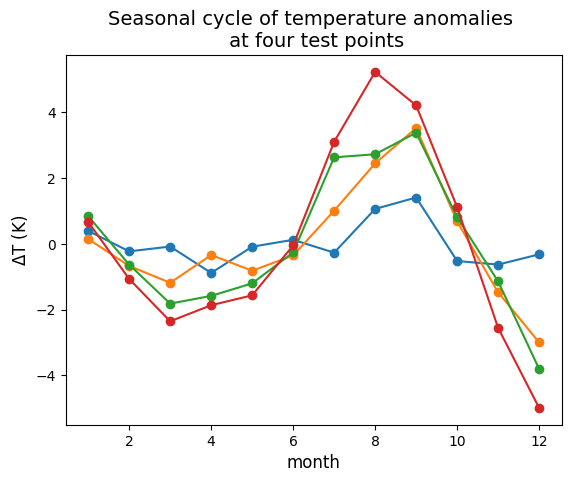

In [30]:
## Test plot seasonal cycle at a few gridpoint locations

# Points to plot seasonal cycle at:
lat_points = (38, 38, 38, 38)
lon_points = (-123.25, -125, -128, -132)

fig = plt.figure()
ax = plt.axes()

for lat, lon in zip(lat_points, lon_points):
    scycle_point = seasonal_cycle.sel(lat=lat, lon=lon)
    ax.plot(scycle_point['month'], scycle_point.values, 'o-')

ax.set_title("Seasonal cycle of temperature anomalies \n at four test points", fontsize=14)
ax.set_xlabel("month", fontsize=12)
ax.set_ylabel(r"$\Delta$T (K)", fontsize=12)

### 4.2 Optional: Using a distributed cluster
We use the third party software/package Coiled to spin up our distributed cluster.

In [65]:
cluster = coiled.Cluster(
    n_workers=25, 
    region="us-west-2", 
    worker_vm_types="c7g.large", # or can try "m7a.medium"
    scheduler_vm_types="c7g.large", # or can try "m7a.medium"
    ) 
client = cluster.get_client()

Output()

Output()

***Note that computations on the distributed cluster work if we fully load the reference information into memory first, but not if we just pass the path to the reference file!***

In [66]:
%%time

##==================================================================
## Only works if the reference is loaded into memory first!!!!
##==================================================================
with open("ref_combined_2019.json") as f:
    ref_loaded = json.load(f)
data = opendf_withref(ref_loaded, fs)
sst = data['analysed_sst']
sst = sst.chunk(chunks={'lat': 300, 'lon': 300, 'time': 200})
print(sst)

<xarray.DataArray 'analysed_sst' (time: 365, lat: 17999, lon: 36000)>
dask.array<rechunk-merge, shape=(365, 17999, 36000), dtype=float32, chunksize=(200, 300, 300), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.99 -89.98 -89.97 -89.96 ... 89.97 89.98 89.99
  * lon      (lon) float32 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time     (time) datetime64[ns] 2019-01-01T09:00:00 ... 2019-12-31T09:00:00
Attributes: (7)
CPU times: user 3.64 s, sys: 936 ms, total: 4.58 s
Wall time: 4.03 s


In [67]:
%%time
seasonal_cycle = seasonal_cycle_regional(sst, lat_region, lon_region).compute()

/opt/coiled/env/lib/python3.12/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 71.82 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 18 s, sys: 7.88 s, total: 25.9 s
Wall time: 46.5 s


Text(0, 0.5, '$\\Delta$T (K)')

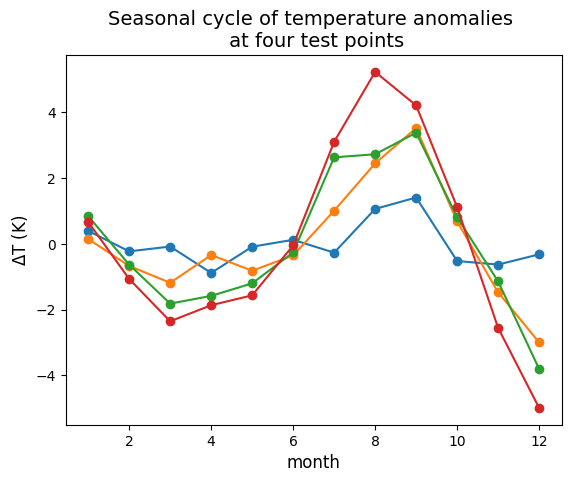

In [68]:
## Test plot seasonal cycle at a few gridpoint locations

# Points to plot seasonal cycle at:
lat_points = (38, 38, 38, 38)
lon_points = (-123.25, -125, -128, -132)

fig = plt.figure()
ax = plt.axes()

for lat, lon in zip(lat_points, lon_points):
    scycle_point = seasonal_cycle.sel(lat=lat, lon=lon)
    ax.plot(scycle_point['month'], scycle_point.values, 'o-')

ax.set_title("Seasonal cycle of temperature anomalies \n at four test points", fontsize=14)
ax.set_xlabel("month", fontsize=12)
ax.set_ylabel(r"$\Delta$T (K)", fontsize=12)

In [69]:
##==================================================================
## Loading the data with the reference this way will lead to errors!!!!
##==================================================================
data = opendf_withref("ref_combined_2019.parq", fs)
sst = data['analysed_sst']
sst = sst.chunk(chunks={'lat': 300, 'lon': 300, 'time': 200})
print(sst)

<xarray.DataArray 'analysed_sst' (time: 365, lat: 17999, lon: 36000)>
dask.array<rechunk-merge, shape=(365, 17999, 36000), dtype=float32, chunksize=(200, 300, 300), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.99 -89.98 -89.97 -89.96 ... 89.97 89.98 89.99
  * lon      (lon) float32 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time     (time) datetime64[ns] 2019-01-01T09:00:00 ... 2019-12-31T09:00:00
Attributes: (7)


In [70]:
%%time
seasonal_cycle = seasonal_cycle_regional(sst, lat_region, lon_region).compute()

RuntimeError: Error during deserialization of the task graph. This frequently
occurs if the Scheduler and Client have different environments.
For more information, see
https://docs.dask.org/en/stable/deployment-considerations.html#consistent-software-environments


In [71]:
client.shutdown()